In [1]:
#matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import pandas as pd
import time
import mpmath
import os

import importlib
import FVMF
importlib.reload(FVMF)
import test_ensemble
importlib.reload(test_ensemble)

prefix = "_phoneme_bg_"
# define the summary writer
writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")


# select the device
DEVICE = torch.device("cuda:1")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
cuda = torch.cuda.set_device(1)

if (torch.cuda.is_available()):
    print("GPUs are used!")
else:
    print("CPUs are used!")

# define the parameters
BATCH_SIZE = 100
TEST_BATCH_SIZE = 100
COND_OPT = False
CLASSES = 5
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 50

#prepare the data
data = pd.read_csv('http://www.uio.no/studier/emner/matnat/math/STK2100/data/phoneme.data')
data = data.drop(columns=["row.names"])
data = pd.concat([data,data.g.astype("category").cat.codes.astype(int)],sort=False, axis=1) #get_dummies(data['g'], prefix='phoneme')],sort=False, axis=1)
data = data.drop(columns=["g","speaker"])
data = data.values

np.random.seed(40590)

tr_ids = np.random.choice(4509, 3500, replace = False)
te_ids = np.setdiff1d(np.arange(4509),tr_ids)[0:1000]

dtrain = data[tr_ids,:]

data_mean = dtrain.mean(axis=0)[0:256]
data_std = dtrain.std(axis=0)[0:256]

data[:,0:256] = (data[:,0:256]  - data_mean)/data_std

dtrain = data[tr_ids,:]
dtest = data[te_ids,:]
print('dtrain:',dtrain.shape)

# set prior parameters
PI = 1
SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.cuda.FloatTensor([math.exp(-6)])

norm_w_mu_layer1 = []

#The net does not like to get larger at a given layer??
l1shape=(256, 10)
l2shape=(10, 10)
l3shape=(10, 10)
l4shape=(10, 5)
layershapes = [l1shape, l2shape, l3shape, l4shape]

epochs = 10
trtimes  = []
# make inference on 10 networks
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net = FVMF.BayesianNetwork(layershapes=layershapes,BN='notbatchnorm',VD='Gaussian',
                               dtrain=dtrain,dtest=dtest,BATCH_SIZE = 100,classification = 'classification').to(DEVICE)
    #net = VMF.BayesianNetwork(l1=l1shape, l2=l2shape, l3=l3shape,l4=l4shape,BN='notbatchnorm').to(DEVICE)
    optimizer = optim.Adam(net.parameters(), lr=0.007)
    for epoch in range(epochs):

        train = FVMF.train(net, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        #print(net.l1.weight_mu.mean())
        norm = 0
        for i in net.weight_mu:
            norm+=torch.norm(i)
        norm_w_mu_layer1.append(norm.detach().cpu().numpy()/len(net.weight_mu))
    res = test_ensemble.test_ensemble(net,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")


x = []
for i in range(epochs):
    x.append(i+1)

#plt.xlabel('Epoch')
#plt.ylabel('Loss')
print('Gaussian loss, 10 epoch phoneme classification')
#plt.plot(x,trtimes)
##plt.savefig('Plots/Gaussian_loss_10_epoch_phoneme_classification.png')
#plt.show()

GPUs are used!
FVMF RELOADED
GPUs are used!
FVMF RELOADED
GPUs are used!
dtrain: (3500, 257)
0
Random Init Utilized


/opt/uio/modules/rhel8/easybuild/software/Miniconda3/lmsunde/envs/BNN2/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


1
loss: tensor(350.0442, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(49.1581, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(297.2805, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(16.6147, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(276.6905, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(13.7142, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(256.4194, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(12.5797, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(239.7066, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(13.1582, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(219.7606, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(12.9421, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(201.7312, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihoo

In [2]:
#import importlib
#import os
import FVMF
importlib.reload(FVMF)

#import VMF

#import importlib
#importlib.reload(VMF)

prefix = "_phoneme_bg_"
# define the summary writer
writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")


# select the device
DEVICE = torch.device("cuda:1")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
cuda = torch.cuda.set_device(1)

# define the parameters
BATCH_SIZE = 100
TEST_BATCH_SIZE = 100
batch_size = 100
COND_OPT = False
CLASSES = 5
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 50

#prepare the data
data = pd.read_csv('http://www.uio.no/studier/emner/matnat/math/STK2100/data/phoneme.data')
data = data.drop(columns=["row.names"])
data = pd.concat([data,data.g.astype("category").cat.codes.astype(int)],sort=False, axis=1) #get_dummies(data['g'], prefix='phoneme')],sort=False, axis=1)
data = data.drop(columns=["g","speaker"])
data = data.values

np.random.seed(40590)

tr_ids = np.random.choice(4509, 3500, replace = False)
te_ids = np.setdiff1d(np.arange(4509),tr_ids)[0:1000]

dtrain = data[tr_ids,:]

data_mean = dtrain.mean(axis=0)[0:256]
data_std = dtrain.std(axis=0)[0:256]

data[:,0:256] = (data[:,0:256]  - data_mean)/data_std

dtrain = data[tr_ids,:]
dtest = data[te_ids,:]

# set prior parameters
PI = 1
SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.cuda.FloatTensor([math.exp(-6)])

epochs = 10
trtimes  = []
norm_w_mu_layer1 = []
#w_mu = [w_mu1, w_mu2, w_mu3, w_mu4]
#b_mu = [b_mu1, b_mu2, b_mu3, b_mu4]

#w_mu_nodewise = [w_mu1_nodewise,w_mu2_nodewise,w_mu3_nodewise,w_mu4_nodewise]
#b_mu_nodewise = [b_mu1_nodewise,b_mu2_nodewise,b_mu3_nodewise,b_mu4_nodewise]
# make inference on 10 networks

for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net2 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.5,6.6),
                                Temper = 1, normalize = 'No',classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #p.requires_grad_(False)
    
    #for j,p in enumerate(net2.l2.parameters()):
    #p.requires_grad_(False)
    
    optimizer = optim.Adam(net2.parameters(), lr=0.14)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        norm = 0
        for i in net2.weight_mu:
            norm+=torch.norm(i)
        norm_w_mu_layer1.append(norm.detach().cpu().numpy()/len(net2.weight_mu))
        print('max:',net2.weight_mu[1].max())
        print('norm:',torch.norm(net2.weight_mu[1]))

    res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
print('vMF loss, 10 epoch phoneme classification')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.plot(x,trtimes)
#plt.savefig('Plots/vMF_loss_10_epoch_phoneme_classification.png')
#plt.show()

GPUs are used!
FVMF RELOADED
0
Random Init Utilized


/opt/uio/modules/rhel8/easybuild/software/Miniconda3/lmsunde/envs/BNN2/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


1
loss: tensor(208.9301, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(53.8483, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(4.3046, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(15.0372, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(198.2865, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(17.0525, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(4.9646, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(17.5934, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(169.0435, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(19.6990, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(5.8137, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(18.7951, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(159.2988, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(15.4887, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(6.060

In [3]:
epochs = 30
trtimes  = []
norm_w_mu_layer1 = []
# make inference on 10 networks
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net = FVMF.BayesianNetwork(layershapes=layershapes,BN='notbatchnorm',VD='Gaussian',
                               dtrain=dtrain,dtest=dtest,BATCH_SIZE = 100,classification = 'classification').to(DEVICE)
    #net = VMF.BayesianNetwork(l1=l1shape, l2=l2shape, l3=l3shape,l4=l4shape,BN='notbatchnorm').to(DEVICE)
    optimizer = optim.Adam(net.parameters(), lr=0.003)
    for epoch in range(epochs):

        train = FVMF.train(net, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        norm = 0
        for i in net.weight_mu:
            norm+=torch.norm(i)
        norm_w_mu_layer1.append(norm.detach().cpu().numpy()/len(net.weight_mu))

    res = test_ensemble.test_ensemble(net,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))
x = []
for i in range(epochs):
    x.append(i+1)
print('Gaussian loss curve, 30 epoch phoneme classification')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.plot(x,trtimes)
#plt.savefig('Plots/Gaussian_loss_30_epoch_phoneme_classification.png')
#plt.show()

0
Random Init Utilized
1
loss: tensor(412.0250, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(100.9529, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(338.8826, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(37.1010, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(317.0960, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(22.0465, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(303.8429, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(17.2404, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(295.4734, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(15.6428, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(285.1866, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(14.7633, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(275.3525, device='cuda:1', grad_fn=<AddBackward0>

In [4]:
trtimes = []
norm_w_mu_layer1 = []
epochs = 30
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net22 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.5,6.6),
                                Temper = 1, normalize = 'No',classification = 'classification')
    #for j,p in enumerate(net2.l1.parameters()):    
    #p.requires_grad_(False)
    
    #for j,p in enumerate(net2.l2.parameters()):
    #p.requires_grad_(False)
    
    optimizer = optim.Adam(net22.parameters(), lr=0.035)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net22, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        norm = 0
        for i in net.weight_mu:
            norm+=torch.norm(i)
        norm_w_mu_layer1.append(norm.detach().cpu().numpy()/len(net.weight_mu))
        print('max:',net22.weight_mu[1].max())
        print('norm:',torch.norm(net22.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
print('vMF loss, 30 epoch phoneme classification without NII')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.plot(x,trtimes)
#plt.savefig('Plots/vMF_loss_30_epoch_phoneme_classification_without_NII.png')
#plt.show()
res = test_ensemble.test_ensemble(net22,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

0
Random Init Utilized
1
loss: tensor(236.7406, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(79.1357, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(2.3362, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(11.8259, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(209.9905, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(45.3556, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(2.8906, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(11.7916, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(197.3064, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(39.7432, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(3.7135, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(11.7596, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(198.7411, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(40.7713, device='cuda:1', grad_fn=<NllLossBackwa

Component 0 Accuracy: 926.0/1000
Component 1 Accuracy: 924.0/1000
Component 2 Accuracy: 922.0/1000
Component 3 Accuracy: 925.0/1000
Component 4 Accuracy: 930.0/1000
Component 5 Accuracy: 918.0/1000
Component 6 Accuracy: 924.0/1000
Component 7 Accuracy: 928.0/1000
Component 8 Accuracy: 921.0/1000
Component 9 Accuracy: 925.0/1000
Posterior Mean Accuracy: 931.0/1000
Ensemble Accuracy: 929/1000


In [5]:
trtimes = []
norm_w_mu_layer2 = []
epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net2 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.5,6.6),
                                Temper = 1, normalize = 'No',classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #p.requires_grad_(False)
    
    #for j,p in enumerate(net2.l2.parameters()):
    #p.requires_grad_(False)
    
    optimizer = optim.Adam(net2.parameters(), lr=0.14)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        norm = 0
        for i in net2.weight_mu:
            norm+=torch.norm(i)
        norm_w_mu_layer2.append(norm.detach().cpu().numpy()/len(net2.weight_mu))
        
        print('max:',net2.weight_mu[1].max())
        print('norm:',torch.norm(net2.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
    
w_mu = []
for i in range(len(net2.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net2.weight_mu[i]/torch.norm(net2.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net2.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net2.bias_mu[i]/torch.norm(net2.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net2.bias_rho)):
    b_rho.append(net2.bias_rho[i])

w_rho= []
for i in range(len(net2.weight_rho)):
    w_rho.append(net2.weight_rho[i])
epochs = 20
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net2_2 = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho,
                                Temper = 1, normalize = 'No',classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #p.requires_grad_(False)
    
    #for j,p in enumerate(net2.l2.parameters()):
    #p.requires_grad_(False)
    
    optimizer = optim.Adam(net2_2.parameters(), lr=0.04)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net2_2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        norm = 0
        for i in net2_2.weight_mu:
            norm+=torch.norm(i)
        norm_w_mu_layer2.append(norm.detach().cpu().numpy()/len(net2_2.weight_mu))
        
        print('max:',net2_2.weight_mu[1].max())
        print('norm:',torch.norm(net2_2.weight_mu[1]))


print('vMF loss, 30 epoch phoneme classification with NII')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.plot(x,trtimes)
#plt.savefig('Plots/vMF_loss_30_epoch_phoneme_classification_with_NII.png')
#plt.show()
res = test_ensemble.test_ensemble(net2_2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

0
Random Init Utilized
1
loss: tensor(208.9301, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(53.8483, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(4.3046, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(15.0372, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(198.2865, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(17.0525, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(4.9646, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(17.5934, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(169.0435, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(19.6990, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(5.8137, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(18.7951, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(159.2988, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(15.4887, device='cuda:1', grad_fn=<NllLossBackwa

Component 0 Accuracy: 918.0/1000
Component 1 Accuracy: 911.0/1000
Component 2 Accuracy: 921.0/1000
Component 3 Accuracy: 924.0/1000
Component 4 Accuracy: 926.0/1000
Component 5 Accuracy: 917.0/1000
Component 6 Accuracy: 913.0/1000
Component 7 Accuracy: 919.0/1000
Component 8 Accuracy: 921.0/1000
Component 9 Accuracy: 913.0/1000
Posterior Mean Accuracy: 926.0/1000
Ensemble Accuracy: 931/1000


In [6]:
w_mu = []
for i in range(len(net2_2.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net2_2.weight_mu[i]/torch.norm(net2_2.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net2_2.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net2_2.bias_mu[i]/torch.norm(net2_2.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net2_2.bias_rho)):
    b_rho.append(net2_2.bias_rho[i])

w_rho= []
for i in range(len(net2_2.weight_rho)):
    w_rho.append(net2_2.weight_rho[i])

In [7]:
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net2_2_2 = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho,
                                Temper = 1, normalize = 'No',classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #p.requires_grad_(False)
    
    #for j,p in enumerate(net2.l2.parameters()):
    #p.requires_grad_(False)
    
    optimizer = optim.Adam(net2_2_2.parameters(), lr=0.020) #0.0225
    
    
    for epoch in range(epochs):

        train = FVMF.train(net2_2_2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        norm = 0
        for i in net2_2_2.weight_mu:
            norm+=torch.norm(i)
        norm_w_mu_layer2.append(norm.detach().cpu().numpy()/len(net2_2_2.weight_mu))
        #print('max:',net2_2_2.weight_mu[1].max())
        #print('norm:',torch.norm(net2_2_2.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

0
1
loss: tensor(174.9108, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(23.2045, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(182.5395, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(32.7219, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(164.7686, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(13.9291, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(165.2942, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(15.1001, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(166.2408, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(15.6871, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(164.2401, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(12.8918, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(163.2240, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelih

In [8]:
res = test_ensemble.test_ensemble(net2_2_2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

Component 0 Accuracy: 923.0/1000
Component 1 Accuracy: 909.0/1000
Component 2 Accuracy: 922.0/1000
Component 3 Accuracy: 919.0/1000
Component 4 Accuracy: 921.0/1000
Component 5 Accuracy: 919.0/1000
Component 6 Accuracy: 909.0/1000
Component 7 Accuracy: 916.0/1000
Component 8 Accuracy: 920.0/1000
Component 9 Accuracy: 914.0/1000
Posterior Mean Accuracy: 926.0/1000
Ensemble Accuracy: 929/1000


vMF loss, 50 epoch phoneme classification with NII


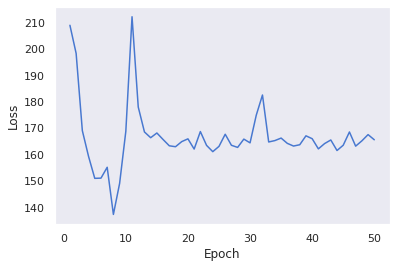

In [9]:
x = []

for i in range(50):
    x.append(i+1)
print('vMF loss, 50 epoch phoneme classification with NII')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trtimes)
plt.savefig('Plots/vMF_loss_50_epoch_phoneme_classification_with_NII.png', dpi=250)
plt.show()


NIIvMF weight average mu norm per epoch


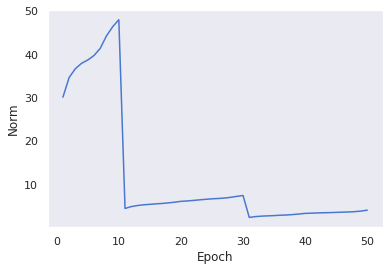

In [10]:
x = []
for i in range(50):
    x.append(i+1)
print('NIIvMF weight average mu norm per epoch')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.plot(x,norm_w_mu_layer2)
plt.savefig('Plots/Phoneme_NIIvMF_norm_50_epoch.png', dpi=250)
plt.show()

0
Random Init Utilized
1
loss: tensor(350.0442, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(49.1581, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(297.2805, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(16.6147, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(276.6905, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(13.7142, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(256.4194, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(12.5797, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(239.7066, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(13.1582, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(219.7606, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(12.9421, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(201.7312, device='cuda:1', grad_fn=<AddBackward0>)

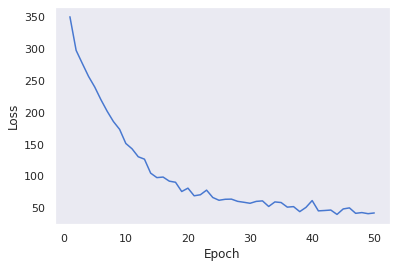

In [11]:
epochs = 50
trtimes  = []
norm_w_mu_layer1 = []
# make inference on 10 networks
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net = FVMF.BayesianNetwork(layershapes=layershapes,BN='notbatchnorm',VD='Gaussian',
                               dtrain=dtrain,dtest=dtest,BATCH_SIZE = 100,classification = 'classification').to(DEVICE)
    #net = VMF.BayesianNetwork(l1=l1shape, l2=l2shape, l3=l3shape,l4=l4shape,BN='notbatchnorm').to(DEVICE)
    optimizer = optim.Adam(net.parameters(), lr=0.007)
    for epoch in range(epochs):

        train = FVMF.train(net, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        #print(net.l1.weight_mu.mean())
        norm = 0
        for i in net.weight_mu:
            norm+=torch.norm(i)
        norm_w_mu_layer1.append(norm.detach().cpu().numpy()/len(net.weight_mu))

    res = test_ensemble.test_ensemble(net,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))
x = []
for i in range(epochs):
    x.append(i+1)
print('Gaussian loss curve, 50 epoch phoneme classification')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trtimes)
plt.savefig('Plots/Gaussian_loss_50_epoch_phoneme_classification.png', dpi=250)
plt.show()

Gaussian weight average mu norm per epoch


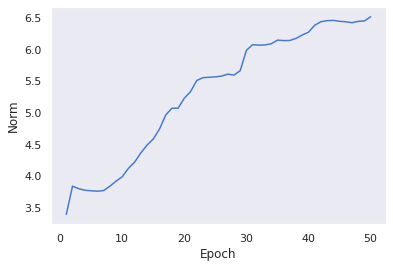

In [12]:
x = []
for i in range(50):
    x.append(i+1)
print('Gaussian weight average mu norm per epoch')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.plot(x,norm_w_mu_layer1)
plt.savefig('Plots/Phoneme_Gaussian_norm_50_epoch.png', dpi=250)
plt.show()

0
Random Init Utilized
1
loss: tensor(236.7406, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(79.1357, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(209.9905, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(45.3556, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(197.3064, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(39.7432, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(198.7411, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(40.7713, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(172.6333, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(14.4437, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(174.6837, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(15.2563, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(178.7253, device='cuda:1', grad_fn=<AddBackward0>)

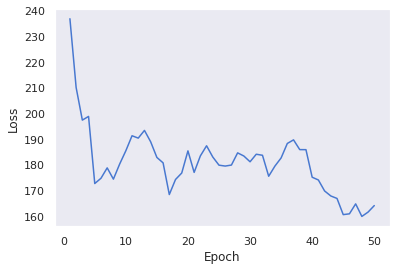

Component 0 Accuracy: 918.0/1000
Component 1 Accuracy: 913.0/1000
Component 2 Accuracy: 911.0/1000
Component 3 Accuracy: 915.0/1000
Component 4 Accuracy: 914.0/1000
Component 5 Accuracy: 919.0/1000
Component 6 Accuracy: 920.0/1000
Component 7 Accuracy: 916.0/1000
Component 8 Accuracy: 924.0/1000
Component 9 Accuracy: 911.0/1000
Posterior Mean Accuracy: 926.0/1000
Ensemble Accuracy: 925/1000


In [13]:
trtimes = []
norm_w_mu_layer1 = []
epochs = 50
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net22 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.5,6.6),
                                Temper = 1, normalize = 'No',classification = 'classification')
    #for j,p in enumerate(net2.l1.parameters()):    
    #p.requires_grad_(False)
    
    #for j,p in enumerate(net2.l2.parameters()):
    #p.requires_grad_(False)
    
    optimizer = optim.Adam(net22.parameters(), lr=0.035)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net22, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        norm = 0
        for i in net22.weight_mu:
            norm+=torch.norm(i)
        norm_w_mu_layer1.append(norm.detach().cpu().numpy()/len(net22.weight_mu))
        #print('max:',net22.weight_mu[1].max())
        #print('norm:',torch.norm(net22.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
print('vMF loss, 50 epoch phoneme classification without NII')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trtimes)
plt.savefig('Plots/vMF_loss_50_epoch_phoneme_classification_without_NII.png', dpi=250)
plt.show()
res = test_ensemble.test_ensemble(net22,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

vMF weight average mu norm per epoch


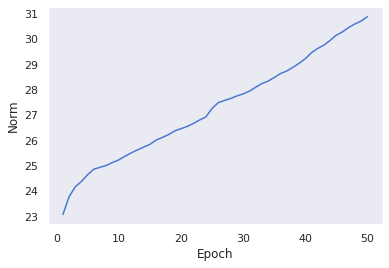

In [14]:
x = []
for i in range(50):
    x.append(i+1)
print('vMF weight average mu norm per epoch')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.plot(x,norm_w_mu_layer1)
plt.savefig('Plots/Phoneme_vMF_norm_50_epoch.png', dpi=250)
plt.show()

In [15]:
#trtimes = []
#norm_w_mu_layer1 = []
#epochs = 10
#for i in range(0, 1):
#    print(i)
#    torch.manual_seed(i)
#    net2 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
#                                #w_mu = None, b_mu = None,
#                                #w_mu = w_mu_nodewise, b_mu = b_mu,
#                                layershapes = layershapes,
#                                dtrain=dtrain, dtest=dtest,
#                                VD='vmf',
#                                b_kappa=torch.Tensor(1).uniform_(4,4.1),
#                                w_kappa=torch.Tensor(1).uniform_(6.5,6.6),
#                                Temper = 1, normalize = 'No',classification = 'classification')
#    
#    #for j,p in enumerate(net2.l1.parameters()):    
#    #p.requires_grad_(False)
#    
#    #for j,p in enumerate(net2.l2.parameters()):
#    #p.requires_grad_(False)
#    
#    optimizer = optim.Adam(net2.parameters(), lr=0.14)
#    
#    
#    for epoch in range(epochs):
#
#        train = FVMF.train(net2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
#        trtimes.append(train[1].detach().cpu().numpy())
#        norm = 0
#        for i in net2.weight_mu:
#            norm+=torch.norm(i)
#        norm_w_mu_layer1.append(norm.detach().cpu().numpy()/len(net2.weight_mu))
#        
#        #print('max:',net2.weight_mu[1].max())
#        #print('norm:',torch.norm(net2.weight_mu[1]))
#
#    #res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))
#
#    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
#    
#w_mu = []
#for i in range(len(net2.weight_mu)):
#    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
#    w_mu.append(net2.weight_mu[i]/torch.norm(net2.weight_mu[i]))
#    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
#    
#b_mu = []
#for i in range(len(net2.bias_mu)):
#    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
#    b_mu.append(net2.bias_mu[i]/torch.norm(net2.bias_mu[i]))
#    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
#    
#b_rho= []
#for i in range(len(net2.bias_rho)):
#    b_rho.append(net2.bias_rho[i])
#
#w_rho= []
#for i in range(len(net2.weight_rho)):
#    w_rho.append(net2.weight_rho[i])
#epochs = 20
#for i in range(0, 1):
#    print(i)
#    torch.manual_seed(i)
#    net2_2 = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
#                                #w_mu = None, b_mu = None,
#                                #w_mu = w_mu_nodewise, b_mu = b_mu,
#                                layershapes = layershapes,
#                                dtrain=dtrain, dtest=dtest,
#                                VD='vmf',
#                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
#                                w_kappa= w_rho,
#                                Temper = 1, normalize = 'No',classification = 'classification')
#    
#    #for j,p in enumerate(net2.l1.parameters()):    
#    #p.requires_grad_(False)
#    
#    #for j,p in enumerate(net2.l2.parameters()):
#    #p.requires_grad_(False)
#    
#    optimizer = optim.Adam(net2_2.parameters(), lr=0.04)
#    
#    
#    for epoch in range(epochs):
#
#        train = FVMF.train(net2_2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
#        trtimes.append(train[1].detach().cpu().numpy())
#        
#        norm = 0
#        for i in net2_2.weight_mu:
#            norm+=torch.norm(i)
#        norm_w_mu_layer1.append(norm.detach().cpu().numpy()/len(net2_2.weight_mu))
#        
#        #print('max:',net2_2.weight_mu[1].max())
#        #print('norm:',torch.norm(net2_2.weight_mu[1]))
#
#    #res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))
#
#    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
#

    


